<a href="https://colab.research.google.com/github/hiendamvan/text_classification_DL_final/blob/main/Text_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [1]:
import pandas as pd
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load dataset and pre-trained embeddings

In [5]:
df = pd.read_csv('/content/preprocessed_data.csv')
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
df["Input"] = df["Paragraph"].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=256, padding="max_length")
)



In [6]:
inputs = torch.tensor(df["Input"].values.tolist())
labels = torch.tensor(df["Topic"].values.tolist())

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)
test_inputs, val_inputs, test_labels, val_labels = train_test_split(
    test_inputs, test_labels, test_size=0.5, random_state=42
)

In [7]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        padding_idx,
        hidden_dim,
        num_layers,
        num_classes,
        dropout=0.5,
    ):
        super(TextCNN, self).__init__()
        #1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        #2. convolutional layers
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3)
        #3. final, fully-connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)
        #4.dropout and relu layers
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        #5.pooling layers
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        x = self.embedding(x)  # Embedding layer
        # Permute dimensions for CNN before conv layer
        x = x.permute(0, 2, 1)
        # Dropout
        x = self.dropout(x)
        # Apply the convolutional layer
        x = self.conv1(x)
        # Apply ReLU activation
        x = self.relu(x)
        # Max pooling
        x = self.pool(x)
        # Flatten for dense layers
        x = x.flatten(start_dim=1)
        # Apply the final fully connected layer and activation
        x = self.fc(x)
        return x

model = TextCNN(
    vocab_size = tokenizer.vocab_size,
    embedding_dim = 256,
    padding_idx = tokenizer.pad_token_id,
    hidden_dim = 256,
    num_layers = 5,
    num_classes = 15,
    dropout = 0.5
)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_labels)
test_dataset = torch.utils.data.TensorDataset(test_inputs, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)


CrossEntropyLoss()

# Summazire the information about the model

In [31]:
pip install torchinfo

In [32]:
dummy_input = torch.randint(0, tokenizer.vocab_size, (1, 256), dtype=torch.long).to(device)

# Print the summary manually
from torchinfo import summary

print(summary(model, input_data=dummy_input))

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [1, 15]                   --
├─Embedding: 1-1                         [1, 256, 256]             16,384,000
├─Dropout: 1-2                           [1, 256, 256]             --
├─Conv1d: 1-3                            [1, 256, 254]             196,864
├─ReLU: 1-4                              [1, 256, 254]             --
├─AdaptiveMaxPool1d: 1-5                 [1, 256, 1]               --
├─Linear: 1-6                            [1, 15]                   3,855
Total params: 16,584,719
Trainable params: 16,584,719
Non-trainable params: 0
Total mult-adds (M): 66.39
Input size (MB): 0.00
Forward/backward pass size (MB): 1.04
Params size (MB): 66.34
Estimated Total Size (MB): 67.39


In [9]:
train_loss_history = []
val_loss_history = []

# Training and Visualization

In [10]:
for epoch in range(15):
    model.train()
    running_loss = 0.0

    # Training loop
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Tính loss trung bình cho tập train và lưu lại
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

    # Đánh giá trên tập validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Tính loss trung bình cho tập validation và lưu lại
    val_loss = val_running_loss / len(val_loader)
    val_loss_history.append(val_loss)

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1, Train Loss: 1.9228
Validation Loss: 1.2014, Validation Accuracy: 64.63%
Epoch 2, Train Loss: 1.1983
Validation Loss: 0.9578, Validation Accuracy: 71.90%
Epoch 3, Train Loss: 0.9631
Validation Loss: 0.8519, Validation Accuracy: 75.33%
Epoch 4, Train Loss: 0.8289
Validation Loss: 0.8078, Validation Accuracy: 77.30%
Epoch 5, Train Loss: 0.7144
Validation Loss: 0.7842, Validation Accuracy: 77.87%
Epoch 6, Train Loss: 0.6470
Validation Loss: 0.7653, Validation Accuracy: 79.53%
Epoch 7, Train Loss: 0.5768
Validation Loss: 0.7658, Validation Accuracy: 79.67%
Epoch 8, Train Loss: 0.5209
Validation Loss: 0.7784, Validation Accuracy: 80.30%
Epoch 9, Train Loss: 0.4833
Validation Loss: 0.7881, Validation Accuracy: 79.80%
Epoch 10, Train Loss: 0.4553
Validation Loss: 0.8155, Validation Accuracy: 80.53%
Epoch 11, Train Loss: 0.4050
Validation Loss: 0.7764, Validation Accuracy: 82.03%
Epoch 12, Train Loss: 0.3835
Validation Loss: 0.7747, Validation Accuracy: 82.07%
Epoch 13, Train Loss: 0.3

In [11]:
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

f1 = f1_score(true_labels, predicted_labels, average="weighted")
print(f"F1 Score: {f1}")

Accuracy: 0.817
F1 Score: 0.816561094678801


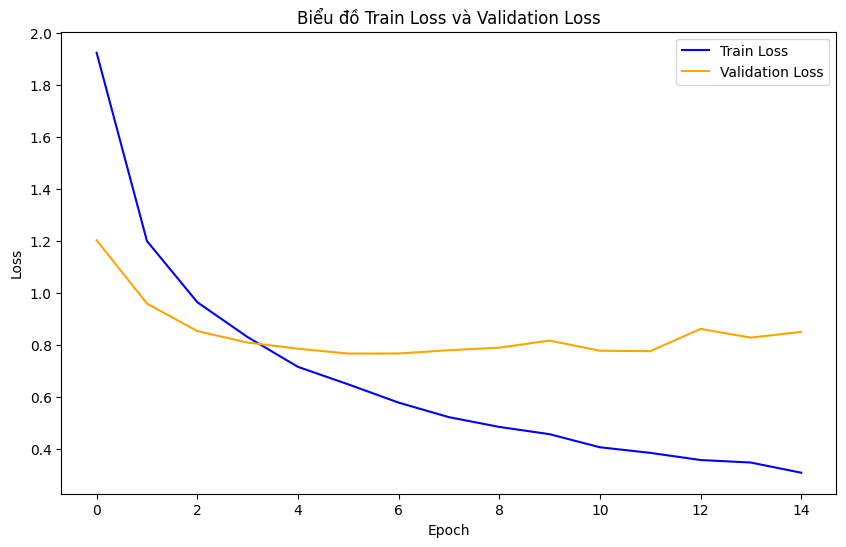

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biểu đồ Train Loss và Validation Loss')
plt.legend()
plt.show()
